## This is a demonstration for using spred to solve the classical lasso problem. 

Actually, this problem is the lasso problem in the rather benign regime, often called the compressive sensing problem.

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np



%matplotlib inline

In [3]:

## to make lasso even slower, try N = 400000
N = 40000
M = 100

## this is a compressive sensing task with sparse feature
A = np.random.normal(0.0, 1.0/ N**0.5, (M, N))
x_0 = np.random.normal(0.0, 1.0, N)
x_0 = np.random.binomial(1.0, 0.1, N) * x_0
y = A @ x_0 + np.random.normal(0.0, 1e-2, M)

In [4]:

lasso = linear_model.Lasso(alpha=1e-5, tol=1e-12, max_iter=1e6, fit_intercept=False)
t1 = time.time()
lasso.fit(A, y)
t2 = time.time()
print(t2 - t1, "sec")

41.64448523521423 sec


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required


import scipy as sp

import sklearn.covariance as cov

## Here is a spred linear perceptron


In [6]:
class Net(nn.Module):
    def __init__(self, dim=N):
        super(Net, self).__init__()
        self.weight = nn.Parameter(torch.zeros(dim).normal_(0, 1/2)) 
        self.weight2 = nn.Parameter(torch.zeros(dim).normal_(0, 1/2)) 

    def forward(self, x):

        return self.weight * self.weight2

model = Net().cuda()
print(model(1))

tensor([ 0.0503, -0.0897, -0.0362,  ...,  0.3150,  0.0060,  0.1836],
       device='cuda:0', grad_fn=<MulBackward0>)


In [7]:
### let us train with Adam

model = Net(dim=40000).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay= 2 * 1e-5)
losses = []

Atorch = torch.tensor(A).cuda().float()
ytorch = torch.tensor(y).cuda().float()

t1 = time.time()
for j in range(10000):
  w = model(1)
  loss = F.mse_loss(Atorch @ w, ytorch)
  opt.zero_grad()
  loss.backward()
  opt.step()
  losses.append(loss.item())
t2 = time.time()
print(t2-t1)

8.839883089065552


[]

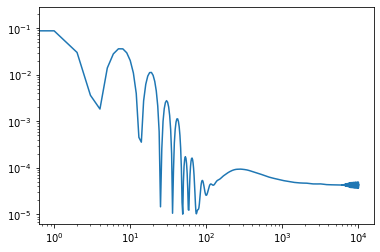

In [8]:
## the model has roughly converged
plt.plot(losses)
plt.loglog()

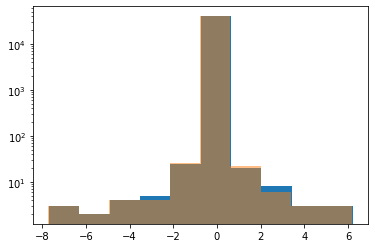

In [9]:
## two distributions agree very well
plt.hist(lasso.coef_)
plt.hist(w.detach().cpu(), alpha=0.5)

plt.yscale('log')

In [10]:
print((w.abs().detach().cpu() < 1e-5).float().mean())
print((w.abs().detach().cpu() < 1e-6).float().mean())
print((w.abs().detach().cpu() < 1e-10).float().mean())
print((w.abs().detach().cpu() == 0).float().mean())

tensor(0.9975)
tensor(0.9975)
tensor(0.9975)
tensor(0.9973)


In [11]:
## the agreement with lasso on the sparse features is very good
torch.tensor((lasso.coef_  == 0)).float().mean()

tensor(0.9976)

In [12]:
## ok now lets try a much harder problem

N = 400000
M = 100

## this is a compressive sensing task with sparse feature
A = np.random.normal(0.0, 1.0/ N**0.5, (M, N))
x_0 = np.random.normal(0.0, 1.0, N)
x_0 = np.random.binomial(1.0, 0.1, N) * x_0
y = A @ x_0 + np.random.normal(0.0, 1e-2, M)

In [13]:
### let us train with Adam

model = Net(dim=N).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay= 2 * 1e-5)
losses = []

Atorch = torch.tensor(A).cuda().float()
ytorch = torch.tensor(y).cuda().float()

t1 = time.time()
for j in range(10000):
  w = model(1)
  loss = F.mse_loss(Atorch @ w, ytorch)
  opt.zero_grad()
  loss.backward()
  opt.step()
  losses.append(loss.item())
t2 = time.time()
print(t2-t1)

7.883856534957886


[]

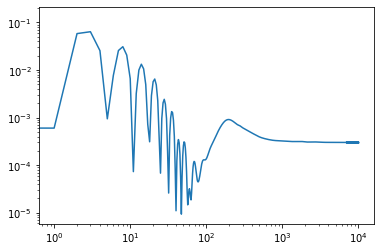

In [14]:
## the model has roughly converged
plt.plot(losses)
plt.loglog()

In [15]:
print((w.abs().detach().cpu() < 1e-5).float().mean())
print((w.abs().detach().cpu() < 1e-6).float().mean())
print((w.abs().detach().cpu() < 1e-10).float().mean())
print((w.abs().detach().cpu() == 0).float().mean())

tensor(0.9998)
tensor(0.9998)
tensor(0.9998)
tensor(0.9997)


In [16]:
## now try lasso if you have the patience

t1 = time.time()
lasso = linear_model.Lasso(alpha=1e-5, tol=1e-12, max_iter=1e6, fit_intercept=False)
lasso.fit(A, y)
t2 = time.time()
print(t2 - t1, "sec")

271.35939359664917 sec


In [17]:
## agreement
torch.tensor((lasso.coef_  == 0)).float().mean()

tensor(0.9998)